# **1.  Import library**

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [36]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# **2. Define VGG model**

In [37]:
OUTPUT_DIM = 10

## VGG-13

### Load pretrain model

In [38]:
import torchvision.models as models
VGG13_model = models.vgg13_bn(pretrained=True)

print(VGG13_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Change classifier layer

In [39]:
VGG13_model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [40]:
IN_FEATURES = VGG13_model.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [41]:
VGG13_model.classifier[-1] = final_fc

In [42]:
VGG13_model.classifier[-1]

Linear(in_features=4096, out_features=10, bias=True)

In [43]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_VGG13_params = count_parameters(VGG13_model)
print(f'The VGG-11 has {num_VGG13_params:,} trainable parameters')

The VGG-11 has 128,997,706 trainable parameters


In [44]:
#Display the number of parameters in model
num_VGG13_params = count_parameters(VGG13_model)
print(f'The VGG-13 has {num_VGG13_params:,} trainable parameters')

The VGG-13 has 128,997,706 trainable parameters


# **3. Data processing**

## Data augmentation workflow

In [45]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding=10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

## Load data

In [46]:
ROOT = '.data'

train_data = datasets.CIFAR10(ROOT,
                              train=True,
                              download=True,
                              transform=train_transforms)

test_data = datasets.CIFAR10(ROOT,
                             train=False,
                             download=True,
                             transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [47]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])


In [48]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [49]:
# Check each split to make sure they are correct
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [50]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image


def plot_images(images, labels, classes, normalize=True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

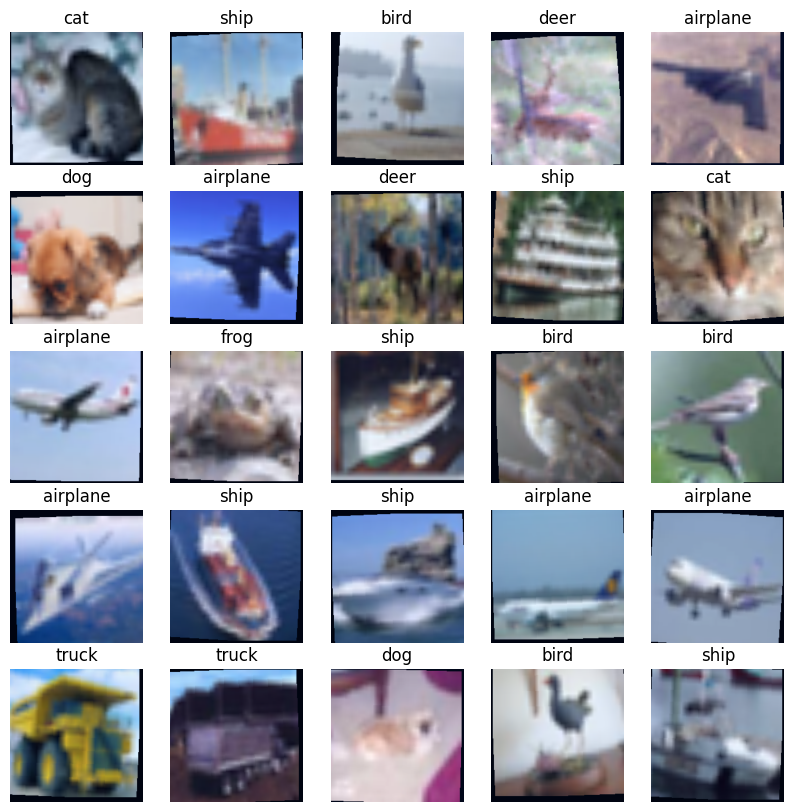

In [51]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

## Data loader

In [52]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

#  **4. Train model**

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()


VGG13_model = VGG13_model.to(device)

criterion = criterion.to(device)

In [54]:
FOUND_LR = 5e-4

VGG13_params = [
          {'params': VGG13_model.features.parameters(), 'lr': FOUND_LR / 10},
          {'params': VGG13_model.classifier.parameters()}
         ]

VGG13_optimizer = optim.Adam(VGG13_params, lr=FOUND_LR)


In [55]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [56]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred= model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [57]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [58]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## VGG-13

In [59]:
EPOCHS = 5

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(VGG13_model, train_iterator, VGG13_optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(VGG13_model, valid_iterator, criterion, device)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 12m 34s
	Train Loss: 0.480 | Train Acc: 84.07%
	 Val. Loss: 0.305 |  Val. Acc: 90.17%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 12m 35s
	Train Loss: 0.262 | Train Acc: 91.57%
	 Val. Loss: 0.274 |  Val. Acc: 90.98%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 12m 35s
	Train Loss: 0.203 | Train Acc: 93.57%
	 Val. Loss: 0.319 |  Val. Acc: 90.13%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 12m 35s
	Train Loss: 0.167 | Train Acc: 94.67%
	 Val. Loss: 0.304 |  Val. Acc: 91.96%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 12m 33s
	Train Loss: 0.139 | Train Acc: 95.62%
	 Val. Loss: 0.305 |  Val. Acc: 91.38%


In [60]:
VGG13_test_loss, VGG13_test_acc = evaluate(VGG13_model, test_iterator, criterion, device)

print(f'Test Loss: {VGG13_test_loss:.3f} | Test Acc: {VGG13_test_acc*100:.2f}%')

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.320 | Test Acc: 91.64%


In [61]:
import pandas as pd

# Assuming you have VGG11_test_loss and VGG11_test_acc values

# Create a DataFrame with a single row
df = pd.DataFrame({
    'Model': ['VGG13'],
    'Test Loss': [VGG13_test_loss],
    'Test Acc': [VGG13_test_acc * 100]
})

# Print the DataFrame
df

,Model,Test Loss,Test Acc
0,VGG13,0.319724,91.643371


In [69]:
df.to_csv('VGG_Series_result.csv', index=False)

In [80]:
import torch
from torchvision import models, transforms
from PIL import Image
import pandas as pd


VGG13_model.eval()

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load an image (replace 'image_path' with the actual path to your image)
image_path = '/content/frog.jpg'
image = Image.open(image_path)

# Preprocess the image
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)
input_batch = input_batch.to(device)

# Make predictions
with torch.no_grad():
    output = VGG13_model(input_batch)

# Get class probabilities
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Create a DataFrame to store class probabilities
class_probs_df = pd.DataFrame({
    "Class": [f"Class {i}" for i in range(len(probabilities))],
    "Probability": [prob.item() * 100 for prob in probabilities]
})

# Transpose the DataFrame
class_probs_df = class_probs_df.set_index("Class").T

# Add a row for the model name
class_probs_df.insert(0, "Model", "VGG13")

# Print the DataFrame
class_probs_df


Class,Model,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9
Probability,VGG13,0.024715,0.0002,1.299926,1.377933,0.016025,0.034859,97.24378,0.000823,0.001354,0.000395


In [84]:
acc = pd.read_csv('/content/VGG_Series_result.csv')
prob = pd.read_csv('/content/VGG_Series_Predict_Probability.csv')

In [85]:
acc = pd.concat([acc, df], ignore_index=True)

In [86]:
acc

,Model,Test Loss,Test Acc
0,VGG11,0.299651,92.052716
1,VGG13,0.319724,91.643371


In [91]:
acc.to_csv('VGG_Series_Accuracy_result.csv',index = False)

In [87]:
prob = pd.concat([prob, class_probs_df], ignore_index=True)

In [88]:
prob

,Model,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9
0,VGG13,1.303668e-14,1.513768e-17,2.641252e-12,7.447396e-12,3.854934e-13,4.377664e-16,100.00000,2.522304e-17,3.101837e-16,3.297771e-17
1,VGG13,2.471535e-02,1.995394e-04,1.299926e+00,1.377933e+00,1.602473e-02,3.485859e-02,97.24378,8.232717e-04,1.353989e-03,3.946140e-04


In [92]:
prob.to_csv('VGG_Series_Predict_Probability.csv', index=False)